# Fianl - AWS - RNN

### Upload the data required

We use both scans of subjects 1-8 from the PETMR and TRIO dataset for training.

We used the scan of subjects 9-10 also from the PETMR and TRIO dataset for testing.

## FUNCTIONS

In [12]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import sys
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import random

In [2]:
#this function simply uploads the testing and training scans into lists of numpy arrays
#the data is not yet sliced or patched at this stage

#specify in a list what scans to use for training and what scans to use for testing


def get_data(petmr_path, trio_path, scans_dict, input_scanner):
    
    train_val_test_inp = []
    train_val_test_out1 = []
    test_data_inp = []
    test_data_out1 = []
    
    if input_scanner == "PETMR":
        input_path = petmr_path
        output_path = trio_path
    else:
        input_path = trio_path
        output_path = petmr_path       
    
    for key, subjs in scans_dict.iteritems():
        for subj_scan in subjs:
                
            input_scan_image = nib.load(str(input_path) + "/Subj" + str(subj_scan[0]) + "Scan" + str(subj_scan[1]) + "/Brain_Matched.nii.gz")
            input_scan_data = input_scan_image.get_data()
                
            input_bvals_scan, input_bvecs_scan = read_bvals_bvecs(str(input_path) + "/Subj" + str(subj_scan[0]) + "Scan" + str(subj_scan[1]) + "/NODDI.bval",\
                                                          str(input_path) + "/Subj" + str(subj_scan[0]) + "Scan" + str(subj_scan[1]) + "/NODDI.bvec")
            
            
            output_scan_image1 = nib.load(str(output_path) + "/Subj" + str(subj_scan[0]) + "Scan1" + "/Brain_Matched.nii.gz")
            output_scan_data1 = output_scan_image1.get_data()

                
            output_bvals_scan1, output_bvecs_scan1 = read_bvals_bvecs(str(output_path) + "/Subj" + str(subj_scan[0]) + "Scan1/NODDI.bval",\
                                                          str(output_path) + "/Subj" + str(subj_scan[0]) + "Scan1/NODDI.bvec")
            
            #set a threshold value for b=0 values (due to TRIO dataset)
            input_gtab_scan = gradient_table(input_bvals_scan, input_bvecs_scan, b0_threshold=5)
            input_s0s_scan = input_scan_data[:, :, :, input_gtab_scan.b0s_mask]
                
            output_gtab_scan1 = gradient_table(output_bvals_scan1, output_bvecs_scan1, b0_threshold=5)
            output_s0s_scan1 = output_scan_data1[:, :, :, output_gtab_scan1.b0s_mask]
            
            # Use only the first volume, ignore other volumes
            if(key == "train_val_test"):
                print ("Uploading Subject %s Scan %s" % (str(subj_scan[0]), str(subj_scan[1])))
                #append the data to the lists containing the training inputs and outputs
                train_val_test_inp.append(input_s0s_scan[:,:,:,[0]])
                train_val_test_out1.append(output_s0s_scan1[:,:,:,[0]])
            else:
                print ("Testing: Subject %s Scan %s" % (str(subj_scan[0]), str(subj_scan[1])))
                test_data_inp.append(input_s0s_scan[:,:,:,[0]])
                test_data_out1.append(output_s0s_scan1[:,:,:,[0]])
    return (train_val_test_inp, train_val_test_out1, , test_data_inp, test_data_out1, test_data_out2, output_scan_image1.affine)

In [3]:
#This function extracts patches from a scan and appends them to a list.
#This is done for all volumes of a scan (for both the inputs and targets)

def patchify(data_scans_inp, data_scans_out1, data_scans_out2, patch_size):
    
    input_patches_store = []
    target_patches_store1 = []
    target_patches_store2 = []
    
    for scan_no in range(0, len(data_scans_inp)):
        input_scan = data_scans_inp[scan_no]
        target_scan1 = data_scans_out1[scan_no]
        target_scan2 = data_scans_out2[scan_no]
        
        (x,y,z,v) = input_scan.shape
        if((patch_size-1) % 2 != 0):
            print "The patch size is not compatible"
            return
        padding = ((patch_size-1)/2)
        #pad the input scan
        full_padding = ((padding, padding), (padding, padding), (padding,padding), (0,0))
        padded_scan = np.pad(input_scan, full_padding, mode='constant', constant_values=0)

        #extract patches from the input scan

        #iterate through each volume to extract the patches
        for volume in range(0, v):
            for pos_x in range(0, x):
                for pos_y in range(0,y):
                    for pos_z in range(0, z):
                        input_patch = padded_scan[pos_x:pos_x+patch_size, pos_y:pos_y+patch_size, pos_z:pos_z+patch_size, volume]
                        target_voxel1 = target_scan1[pos_x,pos_y,pos_z,volume]
                        target_voxel2 = target_scan2[pos_x,pos_y,pos_z,volume]
                        
                        #store the patch and the target
                        input_patches_store.append(input_patch)
                        target_patches_store1.append(target_voxel1)
                        target_patches_store2.append(target_voxel2)
                        
    return (input_patches_store, target_patches_store1, target_patches_store2)





In [4]:
#This function extracts patches from a scan and appends them to a list.
#This is done for all volumes of a scan (for both the inputs and targets)
#This version of the functions only considers voxels wholly contained within the brain

def patchify_brain_only(data_scans_inp, data_scans_out1, data_scans_out2, patch_size):
    
    input_patches_store = []
    target_patches_store1 = []
    target_patches_store2 = []
    
    for scan_no in range(0, len(data_scans_inp)):
        input_scan = data_scans_inp[scan_no]
        target_scan1 = data_scans_out1[scan_no]
        target_scan2 = data_scans_out2[scan_no]
        
        (x,y,z,v) = input_scan.shape
        if((patch_size-1) % 2 != 0):
            print "The patch size is not compatible"
            return
        padding = ((patch_size-1)/2)
        #pad the input scan
        full_padding = ((padding, padding), (padding, padding), (padding,padding), (0,0))
        padded_scan = np.pad(input_scan, full_padding, mode='constant', constant_values=0)

        #extract patches from the input scan

        #iterate through each volume to extract the patches
        for volume in range(0, v):
            for pos_x in range(0, x):
                for pos_y in range(0,y):
                    for pos_z in range(0, z):
                        # Exclude all background voxels
                        if(input_scan[pos_x,pos_y,pos_z,volume] == 0):
                            continue
                        input_patch = padded_scan[pos_x:pos_x+patch_size, pos_y:pos_y+patch_size, pos_z:pos_z+patch_size, volume]
                        target_voxel1 = target_scan1[pos_x,pos_y,pos_z,volume]
                        target_voxel2 = target_scan2[pos_x,pos_y,pos_z,volume]
                        # Exclude all patches that contain artefacts
                        if input_patch.min() < 0:
                            continue
                            
                        #store the patch and the target
                        input_patches_store.append(input_patch)
                        target_patches_store1.append(target_voxel1)
                        target_patches_store2.append(target_voxel2)
                        
    return (input_patches_store, target_patches_store1, target_patches_store2)

In [5]:
def split_data(input_list, output_list1, output_list2, train_prop, val_prop, test_prop):
    length = len(input_list)
    indexes = range(length)
    # Randomly shuffle the indexes
    random.shuffle(indexes)
    
    train_len = int(round(length * train_prop))
    val_len = int(round(length * val_prop))
    test_len = int(length - train_len - val_len)

    train_indices = indexes[:train_len]
    val_indices = indexes[train_len:train_len+val_len]
    test_indices = indexes[train_len+val_len:]

    training_input = [input_list[i] for i in train_indices]
    training_output = [output_list1[i] for i in train_indices]
    
    validation_input = [input_list[i] for i in val_indices]
    validation_output = [output_list1[i] for i in val_indices]
    
    testing_input = [input_list[i] for i in test_indices]
    testing_output1 = [output_list1[i] for i in test_indices]
    testing_output2 = [output_list2[i] for i in test_indices]
    
    return(training_input, training_output, validation_input, validation_output, testing_input, testing_output1, testing_output2)

In [6]:
def viz_pred(inputs, predictions, labels, sliceNo):
    maximum = np.max([inputs.max(), predictions.max(), labels.max()])
    plt.figure
    plt.figure(figsize=(10,10))
    plt.subplot(1, 3, 1).set_axis_off()
    plt.imshow(inputs[:,:,sliceNo,0].T, cmap='gray', origin='lower', vmax = maximum, vmin=0)
    plt.title("Input")
    plt.subplot(1, 3, 2).set_axis_off()
    plt.imshow(predictions[:,:,sliceNo,0].T, cmap='gray', origin='lower', vmax = maximum, vmin=0)
    plt.title("Predicted")
    plt.subplot(1, 3, 3).set_axis_off()
    plt.imshow(labels[:,:,sliceNo,0].T, cmap='gray', origin='lower', vmax = maximum, vmin=0)
    plt.title("Target")
    plt.show()

In [7]:
def viz_diff(predictions, inputs, labels, sliceNo):
    maximum = np.max([inputs.max(), predictions.max(), labels.max()])
    difference = np.abs(predictions[:,:,sliceNo,0] - labels[:,:,sliceNo,0])
    plt.figure
    plt.figure(figsize=(10,10))
    plt.subplot(2, 3, 2).set_axis_off()
    plt.imshow(np.absolute(difference).T, cmap='nipy_spectral', origin='lower')
    #plt.colorbar(shrink=0.2)
    plt.title("Predicted Error")
    plt.subplot(2, 3, 1).set_axis_off()
    plt.imshow(inputs[:,:,sliceNo,0].T, cmap='gray', origin='lower', vmin=0, vmax=maximum)
    plt.title("Input")
    plt.subplot(2, 3, 3).set_axis_off()
    plt.imshow(labels[:,:,sliceNo,0].T, cmap='gray', origin='lower', vmin=0, vmax=maximum)
    plt.title("Target")
    plt.subplot(2, 3, 5).set_axis_off()
    plt.imshow(predictions[:,:,sliceNo,0].T, cmap='gray', origin='lower', vmin=0, vmax=maximum)
    plt.title("Predicted")
    plt.show()

In [8]:
#bland-altman plot

def bland_altman_plot(pred, output1, output2):

    output_mean = np.mean([output1, output2], axis=0)
    x_max = np.max(output_mean)
    diff = pred - output_mean                   # Difference between predicted and mean
    md = np.mean(diff)                   # Mean of the difference
    sd = np.std(diff)            # Standard deviation of the difference
 
    percentage_error = np.absolute(((diff)/(output_mean))*100)
    #percentage_error[percentage_error > 50] = 50
    #percentage_error[percentage_error < -50] = -50
    plt.scatter(output_mean, diff, c=percentage_error, edgecolors='face', cmap='jet')
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    plt.ylabel('Error')
    plt.xlabel('Mean output value')
    plt.xlim([0, x_max*1.1]) 
    plt.colorbar()

In [9]:
def plot_predicted(pred, output1, output2):

    output_mean = np.mean([output1, output2], axis=0)
    x_max = np.max(output_mean)
    diff = pred - output_mean                   # Difference between predicted and mean
    md = np.mean(diff)                   # Mean of the difference
    sd = np.std(diff)            # Standard deviation of the difference
 
    percentage_error = np.absolute(((diff)/(output_mean))*100)
    #percentage_error[percentage_error > 50] = 50
    #percentage_error[percentage_error < -50] = -50
    plt.scatter(output_mean, pred, c=percentage_error, edgecolors='face', cmap='jet')
    plt.ylabel('Predicted')
    plt.xlabel('Mean output value')
    plt.xlim([0, x_max*1.1])
    plt.ylim([0, x_max*1.1]) 
    plt.colorbar()

-------------------------------------------------------------------------------------------------------
---

-------------------------------------------------------------------------------------------------------
---



#### Upload the data

In [11]:
#upload the data
petmr_data_path = '/home/ubuntu/project/Dataset/PETMR_data'
trio_data_path = '/home/ubuntu/project/Dataset/TRIO_data'

# Enter a list of tuples (subject, scan_number)
# Use this to get all scans then split into training, validation and testing
train_val_test_scans = [(1,1), (1,2), (2,1), (2,2), (3,1), (3,2), (4,1), (4,2), (5,1), (5,2), \
                        (6,1), (6,2), (7,1), (7,2), (8,1), (8,2)]

# This is a final test scan only - used to generate a complete scan from the trained CNN
testing_scans = [(8,1), (9,1), (9,2), (10,1), (10,2)]

data_dict = {"train_val_test": train_val_test_scans, "testing":testing_scans}

(train_val_test_inp, train_val_test_out1, train_val_test_out2, final_test_inp, final_test_out1, final_test_out2, affine_mat) = \
        get_data(petmr_data_path, trio_data_path, data_dict, input_scanner="PETMR")
print("Number of scans used for training, validation and testing: %d" % len(train_val_test_inp))
print ("Number of scans used for final testing: %d" % len(final_test_inp))

Uploading Subject 1 Scan 1
Uploading Subject 1 Scan 2
Uploading Subject 2 Scan 1
Uploading Subject 2 Scan 2
Uploading Subject 3 Scan 1
Uploading Subject 3 Scan 2
Uploading Subject 4 Scan 1
Uploading Subject 4 Scan 2
Uploading Subject 5 Scan 1
Uploading Subject 5 Scan 2
Uploading Subject 6 Scan 1
Uploading Subject 6 Scan 2
Uploading Subject 7 Scan 1
Uploading Subject 7 Scan 2
Uploading Subject 8 Scan 1
Uploading Subject 8 Scan 2
Testing: Subject 8 Scan 1
Testing: Subject 9 Scan 1
Testing: Subject 9 Scan 2
Testing: Subject 10 Scan 1
Testing: Subject 10 Scan 2
Number of scans used for training, validation and testing: 16
Number of scans used for final testing: 5


#### Patchify the data

In [12]:
print "Patchifying training, validation and testing set"
(train_val_test_input, train_val_test_target1, train_val_test_target2) = patchify_brain_only(train_val_test_inp, train_val_test_out1, train_val_test_out2, 9)

print "Patchifying final testing scans"
(final_testing_input, final_testing_target1, final_testing_target2) = patchify(final_test_inp, final_test_out1, final_test_out2, 9)

Patchifying training, validation and testing set
Patchifying final testing scans


In [13]:
print ("Nember of training, validation and testing examples : %d" % len(train_val_test_input))
print ("Nember of final testing examples : %d" % len(final_testing_input))

Nember of training, validation and testing examples : 1392748
Nember of final testing examples : 929429


#### Randomly split the data into training validation and testing sets

In [14]:
training_input, training_target, validation_input, validation_target, testing_input, testing_target1, testing_target2 = \
        split_data(train_val_test_input, train_val_test_target1, train_val_test_target2, 0.70, 0.15, 0.15)

In [15]:
print ("Nember of training examples : %d" % len(training_input))
print ("Nember of Validation examples : %d" % len(validation_input))
print ("Nember of testing examples : %d" % len(testing_input))

Nember of training examples : 974924
Nember of Validation examples : 208912
Nember of testing examples : 208912


# PyTorch Functions

In [16]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [17]:
#create a dataset class for our data

class MRIdataset(Dataset):
    """MRI b=0 dataset for patches."""

    def __init__(self, input_patches, target_patches, transform=None):
        """
        Args:
            input_patches: Input patches
            target_patches: Corresponding target patches of the input patches
            transform (callable, optional): Optional transform to be applied
            on a sample.
        """
        self.input_patches = input_patches
        self.target_patches = target_patches
        self.transform = transform

    def __len__(self):
        return len(self.input_patches)

    def __getitem__(self, idx):
        input_patch = np.array(self.input_patches[idx])
        target_patch = np.array(self.target_patches[idx])
        sample = {'input': input_patch, 'target': target_patch}
        

        if self.transform:
            sample = self.transform(sample)
            
        return sample


In [18]:
class To_Tensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        inp, out = sample['input'], sample['target']
        
        #first expand dimension because torch expects H x W x D x C
        #currently we only have H x W x D
        aug_inp = np.expand_dims(inp, 3)
        
        #The target is a single voxel,
        #Conver it to an array
        aug_out = np.array([out])

        # swap channel axis because
        # numpy: H x W x D x C
        # torch: C x D x H x W
        aug_inp = aug_inp.transpose((3, 2, 0, 1))
        
        return {'input': torch.Tensor(aug_inp),
                'target': torch.Tensor(aug_out)}



In [19]:
def train(net, trainloader, valiloader, training_losses, validation_losses, optimizer, criterion, scheduler, epochs):

    for epoch in range(epochs):  # loop over the dataset multiple times
        net.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0): #done in batches
            # get the inputs
            inputs = data['input']
            labels = data['target']

           # wrap them in Variable
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize/update weights
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.data[0] #loss is a variable tensor of size 1, we index to get the value out
            if i % 250 == 249:    # print every 250 mini-batches
                total_loss = running_loss / (i+1)
                print('[%d, %5d] --- Losss = %.5f' % (epoch + 1, i + 1, total_loss))
                
        total_loss = running_loss / (i+1)
        training_losses.append(total_loss)        
        print('Training loss iteration %d = %.5f' % (epoch+1, total_loss ))
        # Update the learning rate dynamically
        scheduler.step(total_loss)
        
        
        # After each epoch evaluat the performance of the CNN on the validation set
        net.eval()   
        validation_error = 0
        total = 0
        for validation_data in valiloader: #batch processing
            validation_inputs = validation_data['input']
            validation_labels = validation_data['target']
            total += 1
            
            validation_inputs, validation_labels = Variable(validation_inputs.cuda()), Variable(validation_labels.cuda())

            validation_predictions = net(validation_inputs)
            
            validation_error += (torch.nn.functional.mse_loss(Variable(validation_predictions.data), validation_labels)).data[0]
            
        validation_error /= total
        print('MSE on validation set: %f' % (validation_error))
        validation_losses.append(validation_error)
 
    print('Finished Training')
    return (net, training_losses, validation_losses)

In [20]:
def plt_losses(training_losses, validation_losses):
    plt.figure
    plt.plot(range(1,len(training_losses)+1), training_losses, 'r-', label="Training error")
    plt.plot(range(1,len(validation_losses)+1), validation_losses, 'b-', label="Validation error")
    plt.legend()
    plt.xlabel('iteration')
    # Make the y-axis label, ticks and tick labels match the line color.
    plt.ylabel('Loss - (MSE)')
    plt.show()

In [21]:
def get_predictions(net, testloader):
    net.eval()
    for index, test_data in enumerate(testloader):
        test_inputs = test_data['input']
        test_labels = test_data['target']
        if index % 250 == 249:
            print index + 1
        
        test_inputs, test_labels = Variable(test_inputs.cuda()), Variable(test_labels.cuda())

        #store the predictions in a numpy array which we can reshape later
        test_predictions = net(test_inputs)
        if(index == 0):
            predictions = test_predictions.data.cpu().numpy() 

        else:
            predictions = np.concatenate((predictions, test_predictions.data.cpu().numpy()), axis=0)
            
    #convert back to numpy dimensions of (HxWxDxCxNumbExpls)
    predictions = predictions.transpose(1,0)
    return predictions
    

In [22]:
def replace_background(prediction, input_scan):
    background_mask = input_scan <= 0
    prediction[background_mask] = 0
    
    return prediction

In [23]:
def reconstruct_brain(predictions, scans):
    # Scans is a list containing the input scans where each scan is stored as a 4d numpy array
    # Iterate through all the scans and reconstruct them
    start_voxel = 0
    reconstructed_scans = []
    for scan in scans:
        dimensions = scan.shape
        size_x = dimensions[0]
        size_y = dimensions[1]
        size_z = dimensions[2]
        size_v = dimensions[3]
        end_voxel = start_voxel + (size_x * size_y * size_z * size_v)
        reconstructed = np.reshape(predictions[:,start_voxel:end_voxel], [size_v, size_x, size_y, size_z], order='C')
        reconstructed = reconstructed.transpose(1,2,3,0)
        start_voxel = end_voxel
        
        # Replace the background voxels of the scan with 0
        reconstructed = replace_background(reconstructed, scan)
        reconstructed_scans.append(reconstructed)
        
    return reconstructed_scans

In [24]:
def get_errors(predictions, output1, output2, data_type):
    
    scan = 0
    mse_avg = 0
    l1_avg = 0
    r1_avg = 0
    
    while True:
        if data_type == "scan":
            scan_predictions = predictions[scan]
            scan_output1 = output1[scan]
            scan_output2 = output2[scan]
            scan += 1
            print('\n--------------Scan %d---------------' % (scan))
        else:
            print('\n----------------------------')
            scan_predictions = predictions
            scan_output1 = output1
            scan_output2 = output2
            
        mse = ((scan_predictions - scan_output1) ** 2).mean()
        print('MSE on test %s: %f' % (data_type, mse))

        l1 = (np.absolute(scan_predictions -  scan_output1)).mean()
        print('Mean absolute loss on test %s: %f' % (data_type, l1))

        r1 = 1 - (np.sum((scan_output1 - scan_predictions) ** 2) / np.sum((scan_output1 - scan_output1.mean()) ** 2))
        print('R2 loss on test %s (Coefficient of determination): %f' % (data_type, r1))

        min_target = np.min([scan_output1, scan_output2], axis=0)
        max_target = np.max([scan_output1, scan_output2], axis=0)
        correct_predictions = np.logical_and(scan_predictions>=min_target, scan_predictions<=max_target)
        correct_predictions = np.sum(correct_predictions)
        percentage_correct = (float(correct_predictions) / float(scan_predictions.size)) * 100
        print('Percentage of predictions within target range: %f' % (percentage_correct))
        
        mse_avg += mse
        l1_avg += l1
        r1_avg += r1
        
        if scan > 0 and scan < len(predictions):
            # Get averages of all the data
            continue
        else:
            break
                    
    if data_type == "scan":
        print '\n------Average of errors across all scans------'
        print ('Avg mse: %f' % (mse_avg/scan))
        print ('Avg l1: %f' % (l1_avg/scan))
        print ('Avg r1: %f' % (r1_avg/scan))

In [25]:
def get_errors_between_targets(output1, output2, data_type):
    
    scan = 0
    mse_avg = 0
    l1_avg = 0
    r1_avg = 0
    
    while True:
        if data_type == "scan":
            scan_output1 = output1[scan]
            scan_output2 = output2[scan]
            scan += 1
            print('\n--------------Scan %d---------------' % (scan))
        else:
            print('\n----------------------------')
            scan_output1 = output1
            scan_output2 = output2
        
        target_mse = ((scan_output1 - scan_output2) ** 2).mean()
        print('MSE between targets: %f' % (target_mse))

        target_l1 = (np.absolute(scan_output2 - scan_output1)).mean()
        print('Mean absolute loss between targets: %f' % (target_l1))

        target_r1 = 1 - (np.sum((scan_output1 - scan_output2) ** 2) / np.sum((scan_output1 - scan_output1.mean()) ** 2))
        print('R2 loss between targets (Coefficient of determination): %f' % (target_r1))
        
        mse_avg += target_mse
        l1_avg += target_l1
        r1_avg += target_r1
        
        if scan > 0 and scan < len(output1):
            # Get averages of all the data
            continue
        else:
            break
                    
    if data_type == "scan":
        print '\n-------Average of errors--------'
        print ('Avg mse: %f' % (mse_avg/scan))
        print ('Avg l1: %f' % (l1_avg/scan))
        print ('Avg r1: %f' % (r1_avg/scan))

-------------------------------------------------------------------------------------------------------
---

-------------------------------------------------------------------------------------------------------
---



### Upload the data using pytorch data loaders

In [26]:
training_dataset = MRIdataset(training_input, training_target, transform=transforms.Compose([To_Tensor()]))
validation_dataset = MRIdataset(validation_input, validation_target, transform=transforms.Compose([To_Tensor()]))
testing_dataset = MRIdataset(testing_input, testing_target1, transform=transforms.Compose([To_Tensor()]))

final_testing_dataset = MRIdataset(final_testing_input, final_testing_target1, transform=transforms.Compose([To_Tensor()]))

In [27]:
trainloader = DataLoader(training_dataset, batch_size=256,
                        shuffle=True, num_workers=16)

valiloader = DataLoader(validation_dataset, batch_size=256,
                        shuffle=True, num_workers=16)

testloader = DataLoader(testing_dataset, batch_size=256,
                        shuffle=False, num_workers=16)

final_test_loader = DataLoader(final_testing_dataset, batch_size=256,
                        shuffle=False, num_workers=16)

### Develop CNN

Conv -> Batch -> Relu -> Conv -> Batch -> Relu -> Conv -> Batch -> Relu -> Conv -> Relu

--(WxHx2x1)--

conv1 = receptive field -> (3x3x3), zero padding -> 2,  number of filters -> 10

--(W+2xH+2x4x10)--

--BATCH then RELU--

conv2 = receptive field -> (1x1x1), number of filters -> 15

--(W+2xH+2x4x15)--

--BATCH then RELU--

conv3 = receptive field -> (3x3x3), number of filters -> 15

--(WxHx2x15)--

--BATCH then RELU--

conv4 = receptive field -> (1x1x2), number of filters -> 1

--(WxHx1x1)--

--RELU--




In [36]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv3d(1, 100, 3, padding=1)
        self.batch1 = nn.BatchNorm3d(100)
        # Skip 1 start
        self.drop1 = nn.Dropout(p=0.10)
        self.conv2 = nn.Conv3d(100, 100, 3, padding=1)
        self.batch2 = nn.BatchNorm3d(100)
        self.drop2 = nn.Dropout(p=0.10)
        self.conv3 = nn.Conv3d(100, 100, 3, padding=1)
        # Skip 1 end
        self.batch3 = nn.BatchNorm3d(100)
        # Skip 2 start
        self.drop3 = nn.Dropout(p=0.10)
        self.conv4 = nn.Conv3d(100, 100, 3, padding=1)
        #self.batch4 = nn.BatchNorm3d(100)
        #self.drop4 = nn.Dropout(p=0.10)
        #self.conv5 = nn.Conv3d(100, 100, 3, padding=1)
        # Skip 2 end
        self.batch5 = nn.BatchNorm3d(100)
        self.drop5 = nn.Dropout(p=0.10)
        self.fc1 = nn.Linear(100*9*9*9, 300)
        self.batch6 = nn.BatchNorm1d(300)
        # Skip 3 start
        self.drop6 = nn.Dropout(p=0.10)
        self.fc2 = nn.Linear(300, 300)
        self.batch7 = nn.BatchNorm1d(300)
        self.drop7 = nn.Dropout(p=0.10)
        self.fc3 = nn.Linear(300, 300)
        # Skip 3 end
        self.batch8 = nn.BatchNorm1d(300)
        self.drop8 = nn.Dropout(p=0.10)
        self.fc4 = nn.Linear(300, 100)
        self.batch9 = nn.BatchNorm1d(100)
        # Skip 4 start
        self.drop9 = nn.Dropout(p=0.10)
        self.fc5 = nn.Linear(100, 100)
        self.batch10 = nn.BatchNorm1d(100)
        self.drop10 = nn.Dropout(p=0.10)
        self.fc6 = nn.Linear(100, 100)
        # Skip 4 end
        self.batch11 = nn.BatchNorm1d(100)
        self.drop11 = nn.Dropout(p=0.10)
        self.fc7 = nn.Linear(100, 1)
 
        
        

    #note this method isn't called explicitly during train, 
    #rather the instance object is called as pytorch is then 
    #able to take care of other stuff in the background
    def forward(self, x):
        x_skip1 = F.relu(self.batch1(self.conv1(x)))
        x = self.drop2(F.relu(self.batch2(self.conv2(self.drop1(x_skip1)))))
        x = self.drop3(F.relu(self.batch3(self.conv3(x))))
        x = self.conv4(x)
        x = self.batch5(F.relu(x + x_skip1))

        x = x.view(-1, 100*9*9*9)
        x_skip3 = self.drop6(F.relu(self.batch6(self.fc1(self.drop5(x)))))
        x = self.drop7(F.relu(self.batch7(self.fc2(x_skip3))))
        x = self.drop8(F.relu(self.batch8(self.fc3(x) + x_skip3)))
        
        x_skip4 = self.drop9(F.relu(self.batch9(self.fc4(x))))
        x = self.drop10(F.relu(self.batch10(self.fc5(x_skip4))))
        x = self.drop11(F.relu(self.batch11(self.fc6(x) + x_skip4)))
        
        x = F.relu(self.fc7(x))
        
        return x


net = Net()
net.cuda()
print(net)

Net(
  (conv1): Conv3d (1, 100, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (batch1): BatchNorm3d(100, eps=1e-05, momentum=0.1, affine=True)
  (drop1): Dropout(p=0.1)
  (conv2): Conv3d (100, 100, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (batch2): BatchNorm3d(100, eps=1e-05, momentum=0.1, affine=True)
  (drop2): Dropout(p=0.1)
  (conv3): Conv3d (100, 100, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (batch3): BatchNorm3d(100, eps=1e-05, momentum=0.1, affine=True)
  (drop3): Dropout(p=0.1)
  (conv4): Conv3d (100, 100, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (batch5): BatchNorm3d(100, eps=1e-05, momentum=0.1, affine=True)
  (drop5): Dropout(p=0.1)
  (fc1): Linear(in_features=72900, out_features=300)
  (batch6): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True)
  (drop6): Dropout(p=0.1)
  (fc2): Linear(in_features=300, out_features=300)
  (batch7): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True)
  (dr

### Define loss function and optimization algorithm

In [37]:
#here we use MSE loss
criterion = nn.MSELoss() #returns the average over a mini-batch as opposed to the sum
optimizer = optim.Adam(net.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=0, verbose=True, threshold=0.08)

In [38]:
training_losses = []
validation_losses = []

### Train CNN

In [39]:
(trained_net, training_losses, validation_losses) = train(net, trainloader, valiloader, training_losses, validation_losses, optimizer, criterion, scheduler, 15)

[1,   250] --- Losss = 48553.24898
[1,   500] --- Losss = 29011.77843
[1,   750] --- Losss = 21838.45010
[1,  1000] --- Losss = 18163.66925
[1,  1250] --- Losss = 15854.81844
[1,  1500] --- Losss = 14258.07124
[1,  1750] --- Losss = 13086.67940
[1,  2000] --- Losss = 12150.03545
[1,  2250] --- Losss = 11413.81720
[1,  2500] --- Losss = 10794.48281
[1,  2750] --- Losss = 10290.33926
[1,  3000] --- Losss = 9858.70123
[1,  3250] --- Losss = 9482.52402
[1,  3500] --- Losss = 9144.92021
[1,  3750] --- Losss = 8847.40573
Training loss iteration 1 = 8784.41635
MSE on validation set: 4197.133442
[2,   250] --- Losss = 4321.92461
[2,   500] --- Losss = 4373.20187
[2,   750] --- Losss = 4314.92400
[2,  1000] --- Losss = 4281.08434
[2,  1250] --- Losss = 4259.51858
[2,  1500] --- Losss = 4239.08076
[2,  1750] --- Losss = 4221.24365
[2,  2000] --- Losss = 4201.70025
[2,  2250] --- Losss = 4176.86307
[2,  2500] --- Losss = 4139.59093
[2,  2750] --- Losss = 4109.55540
[2,  3250] --- Losss = 4072.274

Process Process-332:
Process Process-331:
Process Process-326:
Process Process-328:
Process Process-330:
Process Process-336:
Process Process-325:
  File "/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
Process Process-322:
Traceback (most recent call last):
Process Process-334:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-333:
Process Process-324:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap


    r = index_queue.get()
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/multiprocessing/queues.py", line 376, in get
    r = index_queue.get()
    self._target(*self._args, **self._kwargs)
    racquire()
  File "/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
  File "/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/multiprocessing/queues.py", line 376, in get
    r = index_queue.get()
  File "/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    racquire()
    r = index_queue.get()
    racquire()
    r = index_queue.get()
KeyboardInterrupt
    racquire()
  File "/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/torch/utils/data/dataloader.py", l

KeyboardInterrupt: 

KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


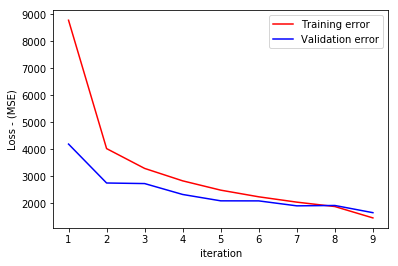

In [40]:
plt_losses(training_losses, validation_losses)

### Calculate the test error - Random patches

In [42]:
# Calculate the error between the predicted voxel values and target1 -- this is from registered scan 1 of the output

# First convert the testing targets to numpy arrays
testing_target1_nump = np.asarray(testing_target1)
testing_target2_nump = np.asarray(testing_target2)

# Get the predicted voxel values of the test set
test_predictions = get_predictions(net, testloader)

250
500
750


In [43]:
get_errors(test_predictions, testing_target1_nump, testing_target2_nump, "patches")


----------------------------
MSE on test patches: 1670.522583
Mean absolute loss on test patches: 26.317799
R2 loss on test patches (Coefficient of determination): 0.955790
Percentage of predictions within target range: 31.572145


In [44]:
get_errors_between_targets(testing_target1_nump, testing_target2_nump, "patches")


----------------------------
MSE between targets: 2383.604248
Mean absolute loss between targets: 28.584316
R2 loss between targets (Coefficient of determination): 0.936919


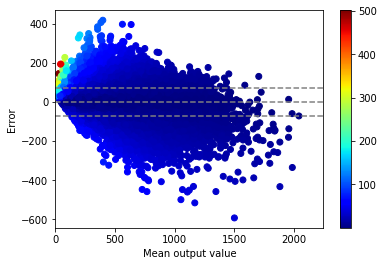

In [45]:
bland_altman_plot(test_predictions, testing_target1_nump, testing_target2_nump)

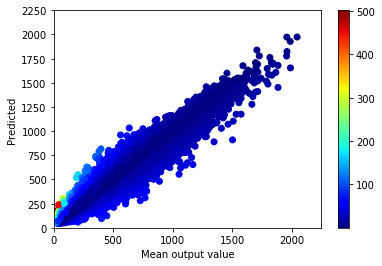

In [46]:
plot_predicted(test_predictions, testing_target1_nump, testing_target2_nump)

### Calculate the error on the final testing scan

In [48]:
final_test_predictions = get_predictions(net, final_test_loader)

250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500


In [49]:
final_predicted_brains = reconstruct_brain(final_test_predictions, final_test_inp)

In [50]:
get_errors(final_predicted_brains, final_test_out1, final_test_out2, "scan")


--------------Scan 1---------------
MSE on test scan: 542.986328
Mean absolute loss on test scan: 10.907972
R2 loss on test scan (Coefficient of determination): 0.987822
Percentage of predictions within target range: 69.194627

--------------Scan 2---------------
MSE on test scan: 1563.626099
Mean absolute loss on test scan: 17.370667
R2 loss on test scan (Coefficient of determination): 0.963289
Percentage of predictions within target range: 65.020321

--------------Scan 3---------------
MSE on test scan: 1417.940674
Mean absolute loss on test scan: 16.981108
R2 loss on test scan (Coefficient of determination): 0.966915
Percentage of predictions within target range: 65.410628

--------------Scan 4---------------
MSE on test scan: 2812.837646
Mean absolute loss on test scan: 21.716278
R2 loss on test scan (Coefficient of determination): 0.933779
Percentage of predictions within target range: 65.623797

--------------Scan 5---------------
MSE on test scan: 2821.066895
Mean absolute loss

In [31]:
get_errors_between_targets(final_test_out1, final_test_out2, "scan")


--------------Scan 1---------------
MSE between targets: 2217.234863
Mean absolute loss between targets: 18.006639
R2 loss between targets (Coefficient of determination): 0.950272

--------------Scan 2---------------
MSE between targets: 789.372437
Mean absolute loss between targets: 12.520751
R2 loss between targets (Coefficient of determination): 0.981467

--------------Scan 3---------------
MSE between targets: 820.377014
Mean absolute loss between targets: 12.804914
R2 loss between targets (Coefficient of determination): 0.980858

--------------Scan 4---------------
MSE between targets: 2180.887207
Mean absolute loss between targets: 19.055370
R2 loss between targets (Coefficient of determination): 0.948657

--------------Scan 5---------------
MSE between targets: 1640.194946
Mean absolute loss between targets: 17.898153
R2 loss between targets (Coefficient of determination): 0.963503

-------Average of errors--------
Avg mse: 1529.613293
Avg l1: 16.057166
Avg r1: 0.964951


### Visualise predictions

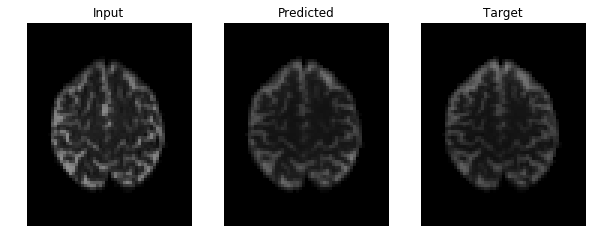

In [56]:
viz_pred(final_test_inp[1], final_predicted_brains[1], final_test_out1[1], 40)

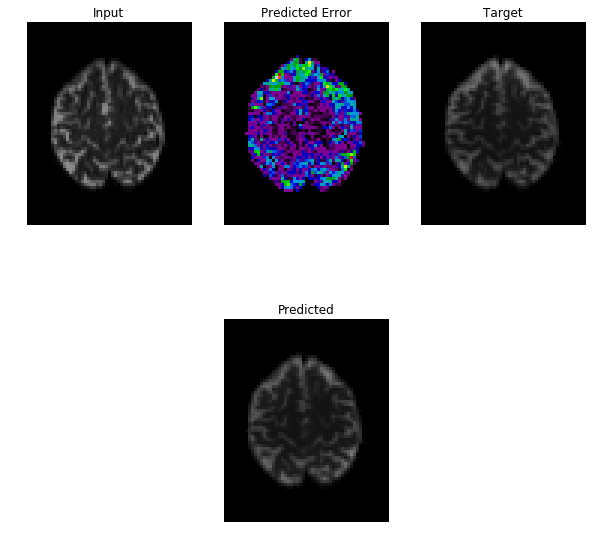

In [59]:
viz_diff(final_predicted_brains[1], final_test_inp[1], final_test_out1[1], 40)

## Save the target and the predicted scans

In [251]:
save_to = "/home/ubuntu/project/Dataset/Final_AWS_1"

predicted_scan = nib.Nifti1Image(final_predicted_brain, affine_mat)
nib.save(predicted_scan, save_to + "/Predicted_Subj9Scan2_AWS.nii.gz" )

## Store the model parameters

In [60]:
torch.save(net.state_dict(), '/home/ubuntu/project/MRIDataHarmonisation/Development/Model_Params_AWS/Final_Model_RNN.pth') 

## Load the model parameters

In [61]:
trained_net = Net()
trained_net.cuda()
trained_net.load_state_dict(torch.load('/home/ubuntu/project/MRIDataHarmonisation/Development/Model_Params_AWS/Final_Model_RNN.pth'))